In [1]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects


# Based on Guides Published Here
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

In [2]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity.copy()
    print(channel_types)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    # raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-5, tmax=30,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [3]:
all_evokeds = defaultdict(list)

subjects = os.listdir("../BIDS_Anon/")
for sub in subjects:
    if sub != ".DS_Store":
        # Create path to file based on experiment info
        f_path = f'../BIDS_Anon/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'

        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)
        
        # Save individual-evoked participant data along with others in all_evokeds
        for cidx, condition in enumerate(epochs.event_id):
            all_evokeds[condition].append(epochs[condition].average())
            
# pprint(all_evokeds)

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
<RawSNIRF | sub-06_task-AnonCom_nirs.snirf, 36 x 18358 (1804.5 s), ~5.2 MB, data loaded>
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-07/nirs/sub-07_task-AnonCom_nirs.snirf
<RawSNIRF | sub-07_task-AnonCom_nirs.snirf, 36 x 17825 (1752.1 s), ~5.1 MB, data loaded>
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-05/nirs/sub-05_task-AnonCom_nirs.snirf
<RawSNIRF | sub-05_task-AnonCom_nirs.snirf, 36 x 17062 (1677.1 s), ~4.8 MB, data loaded>
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-03/nirs/sub-03_task-AnonCom_nirs.snirf
<RawSNIRF | sub-03_task-AnonCom_nirs.snirf, 36 x 22350 (2196.9 s), ~6.3 MB, data loaded>


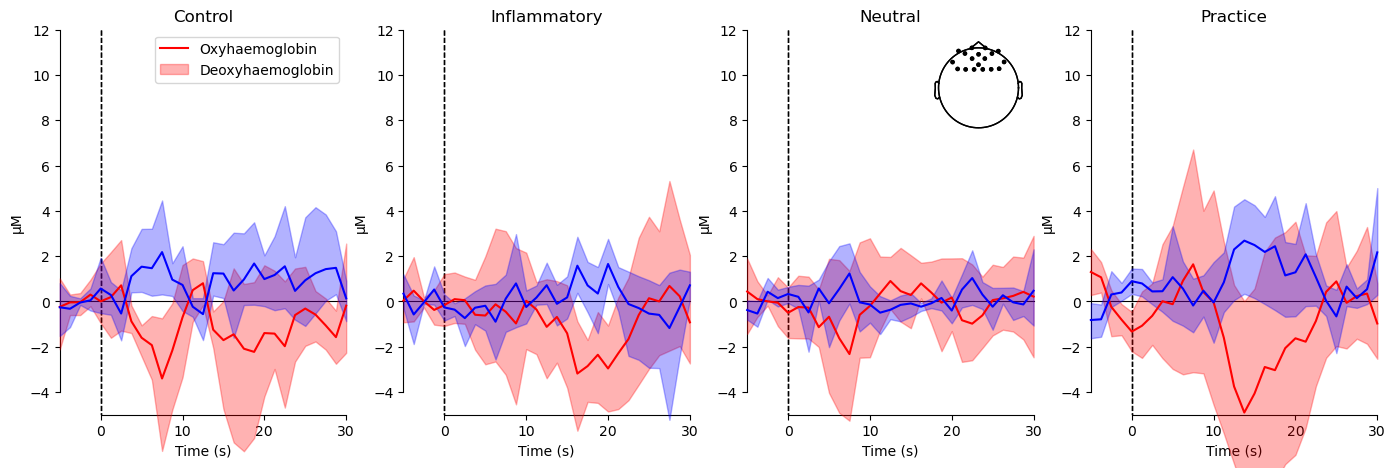

In [4]:
# Print figures

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

In [5]:
# Extract Evoked Amplitude

df = pd.DataFrame(columns=['ID', 'Chroma', 'Condition', 'Value'])

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        for chroma in ["hbo", "hbr"]:
            data = deepcopy(subj_data)
            value = data.crop(tmin=5.0, tmax=7.0).data.mean() * 1.0e6

            # Append metadata and extracted feature to dataframe
            this_df = pd.DataFrame(
                {'ID': subj_id, 'Chroma': chroma,
                 'Condition': evoked, 'Value': value}, index=[0])
            df = pd.concat([df, this_df], ignore_index=True)
df.reset_index(inplace=True, drop=True)
df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df.to_csv("stats-export.csv")

# Print out the first entries in the dataframe
df

,ID,Chroma,Condition,Value
0,1,hbo,Control,-0.408635
1,1,hbr,Control,-0.408635
2,2,hbo,Control,-0.412552
3,2,hbr,Control,-0.412552
4,3,hbo,Control,-0.224928
5,3,hbr,Control,-0.224928
6,4,hbo,Control,-0.114810
7,4,hbr,Control,-0.114810
8,1,hbo,Inflammatory,-1.284203
9,1,hbr,Inflammatory,-1.284203


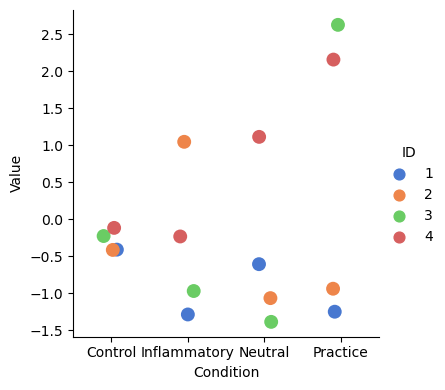

In [6]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)


In [7]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    Value   
No. Observations:    8          Method:                REML    
No. Groups:          4          Scale:                 1.1397  
Min. group size:     2          Log-Likelihood:        -10.3350
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.359    0.538 -0.667 0.505 -1.412  0.695
Condition[T.Neutral] -0.126    0.755 -0.167 0.868 -1.605  1.354
Group Var             0.016    0.634                           
===============================================================

"""